# Training Cavity Model


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import torch
import numpy as np
import gc

import h5py
import pandas as pd
from matplotlib import pyplot as plt

Import local packages


In [16]:
from src.utils.logger import Logging
from src.utils.utils import lp_error
from src.utils.color import model_color
from src.utils.plot_spectral import plot_spectral
from src.utils.plot_loss import plot_loss_history

Set various constant variables: model path, name, etc.


In [5]:
TEST_CHECKPOINT_PATH = "./checkpoint"
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

local_rank = 0
world_size = 1

## Load the Model and Test


In [6]:
TEST_DATA_PKL = "./data/cavity.mat"
data = h5py.File(TEST_DATA_PKL, "r")  # load dataset from matlab

domain = pd.DataFrame(data["cavity_internal"]).T.to_numpy()

#  t = tf.reshape(tstep,N_data)[:,0].T
time_ = domain[:, 0:1]
xfa = domain[:, 1:2]
yfa = domain[:, 2:3]
ufa = domain[:, 3:4]
vfa = domain[:, 4:5]
pfa = domain[:, 5:6]

In [ ]:
config = {
    "problem": "cavity",
    "dataset_path": "./data/cavity.mat",
    "batch_size": 128,
    "total_epochs": 60000,
    "activation": "tanh",
    "network": [3, 50, 50, 50, 3],
    "weights": [2.0, 2.0, 2.0, 2.0, 2.0, 0.1],
    "log_path": TEST_CHECKPOINT_PATH,
    "loss_list": ["lleft", "lright", "lbottom", "lup", "linitial", "lphy"],
    "solver": "tanh",
    "print_every": 100,
    "save_every": 100,
}

In [19]:
from src.trainer import cavity_trainer
from src.nn.tanh_parameterized import PINNKAN
from src.data.cavity_dataset import CavityDatasetFromFile

model = PINNKAN(config.get("network"), config.get("activation")).to("cpu")
obj = CavityDatasetFromFile(config.get("dataset_path"), 0)
train_dataloader = obj.__getitem__()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)


trainer = cavity_trainer.Trainer(
    model,
    train_dataloader,
    optimizer,
    local_rank,
    config,
)

trainer.train_mini_batch()


INFO:src.utils.logger:checkpoint path: self.log_path='./checkpoint/2025-05-24_10-22-12-631256'
INFO:src.utils.logger: Epoch: 0 | Time: 0.02s | rTime: 2.070e-02h | LR: 1.000e-03 |loss: 2.020e+00 | trace_jacobian_bc: 2.640e+02 | trace_jacobian_ic: 1.262e+02 | trace_jacobian_res: 1.683e+00 | lleft: 5.753e-02 | lright: 1.291e-01 | lbottom: 7.011e-02 | lup: 8.837e-01 | linitial: 8.136e-01 | lphy: 6.564e-02 | 
INFO:src.utils.logger:Final losses:
INFO:src.utils.logger:Final lleft: 5.753e-02 |  Final lright: 1.291e-01 |  Final lbottom: 7.011e-02 |  Final lup: 8.837e-01 |  Final linitial: 8.136e-01 |  Final lphy: 6.564e-02 | 
INFO:src.utils.logger:_save_checkpoint: [GPU:0] Epoch 0 | Training checkpoint saved at ./checkpoint/2025-05-24_10-22-12-631256/model.pth


domain.shape=(10100, 6), left.shape=(1515, 6), bottom.shape=(1515, 6), up.shape=(1515, 6), right.shape=(1515, 6), initial.shape=(1500, 6), sensors.shape=(5050, 6)


INFO:src.utils.logger: Epoch: 1 | Time: 0.01s | rTime: 3.480e-02h | LR: 1.000e-03 |loss: 5.127e-01 | trace_jacobian_bc: 7.997e+01 | trace_jacobian_ic: 1.207e+01 | trace_jacobian_res: 1.922e-02 | lleft: 5.402e-02 | lright: 5.335e-02 | lbottom: 3.130e-02 | lup: 2.722e-01 | linitial: 9.788e-02 | lphy: 3.980e-03 | 
INFO:src.utils.logger: Epoch: 2 | Time: 0.02s | rTime: 5.548e-02h | LR: 1.000e-03 |loss: 4.527e-01 | trace_jacobian_bc: 1.910e+01 | trace_jacobian_ic: 2.638e+01 | trace_jacobian_res: 7.655e-02 | lleft: 7.546e-02 | lright: 5.339e-02 | lbottom: 1.155e-02 | lup: 1.899e-01 | linitial: 1.086e-01 | lphy: 1.374e-02 | 
INFO:src.utils.logger: Epoch: 3 | Time: 0.02s | rTime: 7.417e-02h | LR: 1.000e-03 |loss: 3.772e-01 | trace_jacobian_bc: 2.741e+02 | trace_jacobian_ic: 7.167e+00 | trace_jacobian_res: 6.349e-01 | lleft: 5.770e-02 | lright: 4.285e-02 | lbottom: 6.829e-03 | lup: 1.568e-01 | linitial: 6.311e-02 | lphy: 4.992e-02 | 
INFO:src.utils.logger: Epoch: 4 | Time: 0.02s | rTime: 9.327e

In [20]:
model_path = os.path.join(trainer.logger.get_output_dir(), "model.pth")

trace_jacobian_bc_log_dic = {}
trace_jacobian_res_log_dic = {}
trace_jacobian_ic_log_dic = {}

state = torch.load(model_path)
config = state.get("config", {})
solver = config.get("solver")
trace_jacobian_bc_log = state.get("trace_jacobian_bc_log")
trace_jacobian_ic_log = state.get("trace_jacobian_ic_log")
trace_jacobian_res_log = state.get("trace_jacobian_res_log")

model_activation_name = config.get("activation")
model_architecture = config.get("network")
loss_dict = state.get("loss_history")

trace_jacobian_bc_log_dic[model_activation_name] = trace_jacobian_bc_log
trace_jacobian_res_log_dic[model_activation_name] = trace_jacobian_res_log
trace_jacobian_ic_log_dic[model_activation_name] = trace_jacobian_ic_log


/tmp/ipykernel_3393/2994138775.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


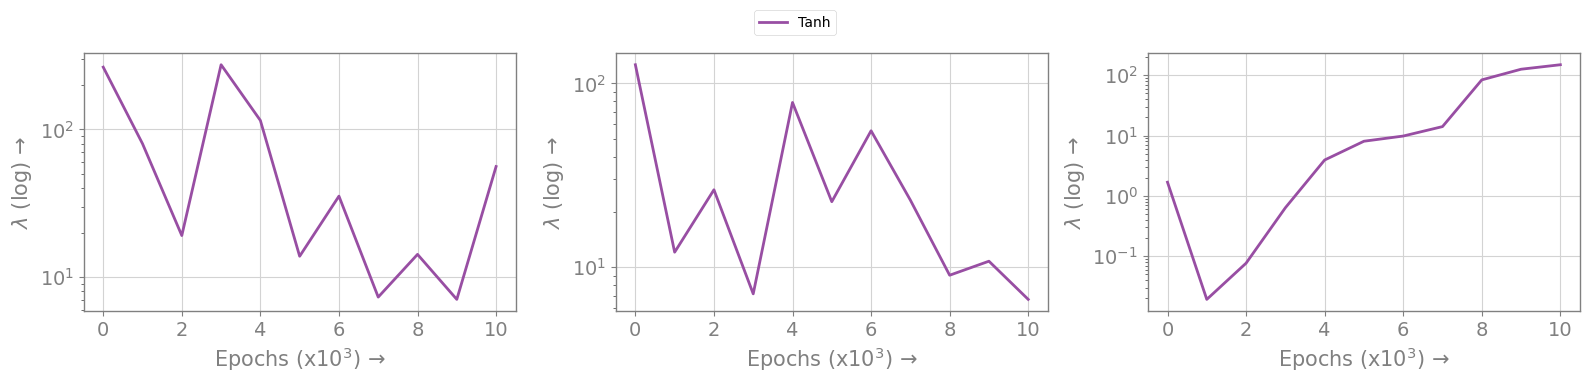

In [21]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([16, 3.5])  # Adjusted figure size
dict_list = [
    trace_jacobian_bc_log_dic,
    trace_jacobian_ic_log_dic,
    trace_jacobian_res_log_dic,
]
lines = []  # List to collect Line2D objects for the legend
labels = []  # List to collect corresponding labels

for index in range(len(dict_list)):
    data_list = [
        # {
        #     "data": dict_list[index]["bspline"],
        #     "color": model_color["bspline"],
        #     "name": "B-spline",
        #     "alpha": 1.0,
        # },
        {
            "data": dict_list[index]["tanh"],
            "color": model_color["tanh"],
            "name": "Tanh",
            "alpha": 1.0,
        },
        # {
        #     "data": dict_list[index]["grbf"],
        #     "color": model_color["grbf"],
        #     "name": "GRBF",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["fourier"],
        #     "color": model_color["fourier"],
        #     "name": "Fourier",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["param_tanh"],
        #     "color": model_color["param_tanh"],
        #     "name": "parametric-Tanh",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["chebyshev"],
        #     "color": model_color["chebyshev"],
        #     "name": "Chebyshev",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["jacobi"],
        #     "color": model_color["jacobi"],
        #     "name": "Jacobi",
        #     "alpha": 1.0,
        # },
    ]

    plot_spectral(ax[index], data_list)

for line in ax[-1].get_lines():
    lines.append(line)
    labels.append(line.get_label())

save_path = os.path.join(logger.get_output_dir(), "spectral_cavity.png")

legend = fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=7
)
legend.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig(save_path)